# Likelihood-free Markov chain Monte Carlo

In [1]:
import torch
import numpy as np
import hypothesis
import matplotlib.pyplot as plt

from torch.distributions.normal import Normal

## Classifier

In [2]:
classifier = torch.load("models/univariate.th")

## Observations

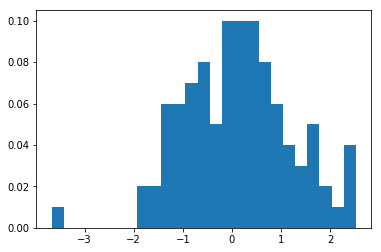

In [3]:
num_observations = 100
theta_true = 0
observations = Normal(theta_true, 1).sample(torch.Size([num_observations])).view(-1, 1)

weights = [1 / num_observations for _ in range(num_observations)]
plt.hist(observations.numpy(), weights=weights, bins=25)
plt.show()

## Analytical Metropolis-Hastings

In [4]:
from hypothesis.inference.mcmc import MetropolisHastings
from hypothesis.transition import Normal as NormalTransition

def log_likelihood(observations, theta):
    return Normal(theta, 1).log_prob(observations).sum()

transition = NormalTransition(1)
sampler = MetropolisHastings(log_likelihood, transition)
theta_0 = torch.tensor(5).float()
result_mh = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=50000,
    burnin_samples=1000)

## Likelihood-free Metropolis-Hastings

In [5]:
from hypothesis.inference.mcmc import ClassifierMetropolisHastings

transition = NormalTransition(1)
sampler = ClassifierMetropolisHastings(classifier, transition)
theta_0 = torch.tensor(5).float()
result_cmh = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=50000,
    burnin_samples=1000)

## Hamiltonian gradients

In [6]:
from hypothesis.inference.mcmc import Hamiltonian
from hypothesis.inference.mcmc import ClassifierHamiltonian

def log_likelihood(observations, theta):
    return Normal(theta, 1).log_prob(observations).sum()

momentum = Normal(0, 1)
sampler = Hamiltonian(log_likelihood, momentum)
sampler_lf = ClassifierHamiltonian(classifier, momentum)

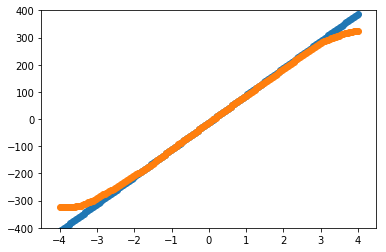

In [7]:
thetas = torch.linspace(-4, 4, 200)
analytical = []
lf = []
for theta in thetas:
    analytical.append(sampler.dU(observations, theta).view(-1))
    lf.append(sampler_lf.dU(observations, theta).view(-1))
analytical = torch.cat(analytical, dim=0)
lf = torch.cat(lf, dim=0)

plt.scatter(thetas.numpy(), analytical.numpy())
plt.scatter(thetas.numpy(), lf.numpy())
plt.ylim([-400, 400])
plt.show()

## Analytical Hamiltonian

In [8]:
from hypothesis.inference.mcmc import Hamiltonian

def log_likelihood(observations, theta):
    return Normal(theta, 1).log_prob(observations).sum()

momentum = Normal(0, 1)
sampler = Hamiltonian(log_likelihood, momentum)
theta_0 = torch.tensor(5).float()
result_h = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=50000,
    burnin_samples=1000)

## Likelihood-free Hamiltonian Monte Carlo

In [9]:
from hypothesis.inference.mcmc import ClassifierHamiltonian

momentum = Normal(0, 1)
sampler = ClassifierHamiltonian(classifier, momentum)
theta_0 = torch.tensor(5).float()
result_ch = sampler.infer(
    observations,
    theta_0=theta_0,
    samples=50000,
    burnin_samples=1000)

## Summary

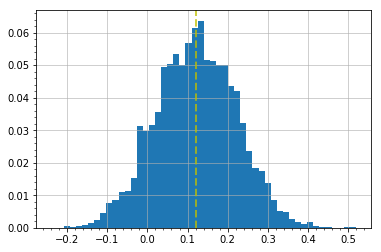

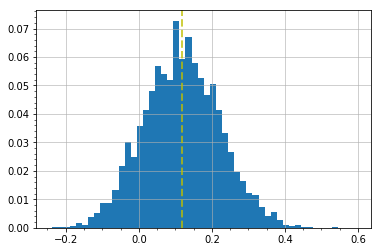

Analytical: tensor(0.1210)
Classifier: tensor(0.1173)


In [10]:
from hypothesis.visualization.mcmc import plot_trace
from hypothesis.visualization.mcmc import plot_autocorrelation
from hypothesis.visualization.mcmc import plot_density

# Metropolis-Hastings
result_mh.min()
plot_density(result_mh, show_mean=True, truth=theta_true, bins=50)
plt.show()
plot_density(result_cmh, show_mean=True, truth=theta_true, bins=50)
plt.show()

print("Analytical:", result_mh.mean())
print("Classifier:", result_cmh.mean())

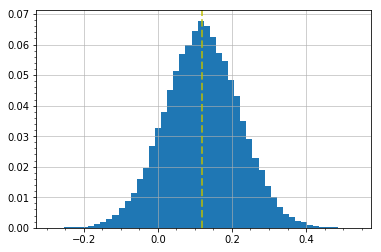

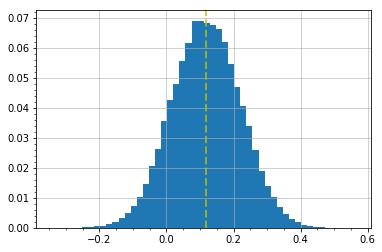

Analytical: tensor(0.1197)
Classifier: tensor(0.1184)


In [11]:
# Hamiltonian
plot_density(result_h, show_mean=True, truth=theta_true, bins=50)
plt.show()
plot_density(result_ch, show_mean=True, truth=theta_true, bins=50)
plt.show()

print("Analytical:", result_h.mean())
print("Classifier:", result_ch.mean())